In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
DEBUG = True

In [18]:
class Ball:
    def __init__(self, team, label, loc):
        self.team = team
        self.label = label
        self.loc = loc

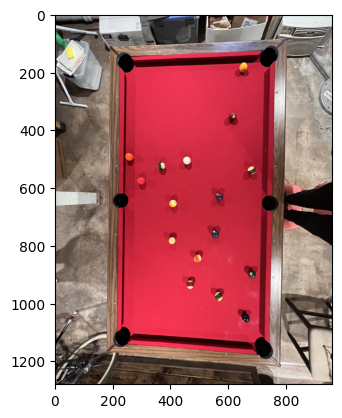

In [19]:
image_path='new_images/all_balls/1280x1280/IMG_2735.png'
grayscale = cv2.imread(image_path, 0)
color = cv2.imread(image_path,1)
if DEBUG:
    plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
    plt.show()

## Threshold by color and mask

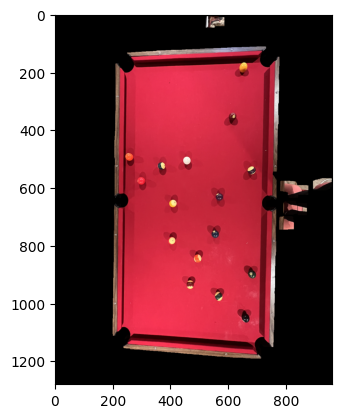

In [20]:
# order is blue, green, red
def mask_table(color_img):
    lower = np.array([0,0,150])
    upper = np.array([150,100,255])
    mask = cv2.inRange(color, lower, upper)
    kernel = np.ones((7,7),np.uint8)
    # erosion = cv2.erode(mask, kernel, iterations=3)
    dilation = cv2.dilate(mask, kernel, iterations=5)
    # dilation is grayscale, lets convert it to have three channels
    rgb_dilation = np.uint8(np.zeros((dilation.shape[0], dilation.shape[1], 3)))
    for i in range(rgb_dilation.shape[0]):
        for j in range(rgb_dilation.shape[1]):
            rgb_dilation[i][j][:] = dilation[i][j]

    res = cv2.bitwise_and(color, rgb_dilation)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    if DEBUG:
        plt.imshow(res)
        plt.show()
    return res

masked_img = mask_table(color)

## Hough Circles

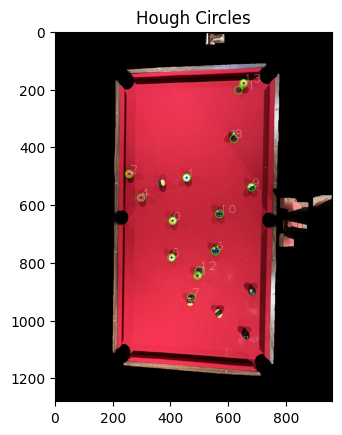

In [21]:
def hough_circles(masked_image):
    cimg = masked_image.copy()
    gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
    h_circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT_ALT,param1=100, param2=0.7, dp=1.5, minRadius=12, maxRadius=15, minDist=11)
    h_circles = np.uint16(np.around(h_circles))

    k = 0
    for i in h_circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.putText(cimg, f'{k}', (i[0],i[1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 1)
        k+=1

    if DEBUG:
        plt.title("Hough Circles")
        plt.imshow(cimg)
    cv2.imwrite('output_images/hough_circles.png', cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))
    return h_circles

circles = hough_circles(masked_img)

## Assume we have correct circles

1


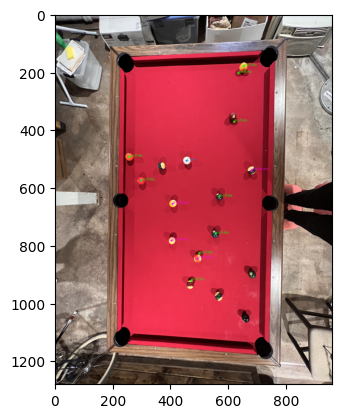

In [22]:
def label_balls(color_img, hough_circs):
    ## get the pixel values of all the circles
    balls = []
    num_solids = 0
    num_stripes = 0
    print(len(hough_circs))
    for circle in hough_circs[0,:]:
        rad = circle[2]
        center_x = circle[1]
        center_y = circle[0]
        # iterate over the box containing the circle
        num_colored = 0
        num_white = 0
        num_black = 0
        for i in range(2*rad):
            for j in range(2*rad):
                tmp_x = center_x - rad + i
                tmp_y = center_y - rad + j
                # check that the point is actually in the circle
                if (tmp_x - center_x)**2 + (tmp_y - center_y)**2 < rad**2:
                    pix = color[tmp_x][tmp_y]
                    white_thresh = 100
                    black_thresh = 50
                    # the white pixels
                    if pix[0] > white_thresh and pix[1] > white_thresh and pix[2] > white_thresh:
                        num_white += 1
                    # the black pixels
                    elif pix[0] < black_thresh and pix[1] < black_thresh and pix[2] < black_thresh:
                        num_black += 1
                    else:
                        num_colored += 1
        total_pixels = num_white + num_black + num_colored
        # print(num_white / total_pixels)
        if num_white / total_pixels >= 0.95:
            ball = Ball(team=None, label="cue", loc=(center_y, center_x))
        elif num_black / total_pixels >= 0.8:
            ball = Ball(team=None, label="eight", loc=(center_y, center_x))
        elif num_white / total_pixels >= 0.25:
            ball = Ball(team="stripes", label=str(num_stripes), loc=(center_y, center_x))
            num_stripes += 1
        else:
            ball = Ball(team="solids", label=str(num_solids), loc=(center_y, center_x))
            num_solids += 1
        balls.append(ball)

    labeled_balls = color_img.copy()
    for b in balls:
        if b.team == 'solids': col = (0,255,0)
        if b.team == 'stripes': col = (255,0,255)
        if b.team == None: col = (255,150,0)
        cv2.putText(labeled_balls, b.team if b.team else b.label, (b.loc[0],b.loc[1]), cv2.FONT_HERSHEY_PLAIN, 1, col, 1)
        cv2.circle(labeled_balls,(b.loc[0],b.loc[1]),2,col,2)

    if DEBUG:
        plt.imshow(cv2.cvtColor(labeled_balls, cv2.COLOR_BGR2RGB))
    cv2.imwrite('output_images/labeled_balls.png', labeled_balls)

label_balls(color_img=color, hough_circs=circles)